<a href="https://colab.research.google.com/github/francealip/assignment_1_ISPR_23-24/blob/main/src/LoG_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2>ASSIGNMENT 7: blob detector with laplacian of a gaussian filter<h2>

<h4><b>Author</b>: Aliprandi Francesco<h4>


<h4><b>1. CODE</b></h4>


In [21]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

#fixing filter size
size = 15


In [22]:
import sys

current_dir = %pwd

parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)

!git clone https://github.com/francealip/assignment_1_ISPR_23-24.git
os.chdir("assignment_1_ISPR_23-24/src")

Cloning into 'assignment_1_ISPR_23-24'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 87 (delta 27), reused 61 (delta 13), pack-reused 0
Receiving objects: 100% (87/87), 4.38 MiB | 17.06 MiB/s, done.
Resolving deltas: 100% (27/27), done.


<h4><b>1.1 Image processing functions</b></h4>

<b>Laplacian of a gaussian:</b> this function create a laplacian of a gaussian filter. It creates a meshgrid and apply the second derivative of the gaussian to each point. It's implemented the normalized version that multiply sigma to the second. Filter size is fixed to be 15 to be enough big for large sigma.

<b>Convolution:</b> implement the convolution with the LoG filter. To get a one-to-one mapping between position in the convolved image and in the real image padding is applied. Padding is performed by copying the edge of the image and not inserting zeros to prevent the edge from contrasting with the padding by revealing the presence of a blob that does not exist on the bord of the image.

<b>Multiple scale execution:</b> implement the convolution with the LoG filters for different scale (sigma). It increase sigma by starting from sigma zero and then multiplying it to power of the two elements. It stores all the convolved images inside a list and return it.

<b>Find local maxima:</b> find a fixed number local maxima in one convolved image and store them in a quadrupla (x position, y position, value of the pixel, sigma). The idea is to scan the image using a size x size window that select the local maxima for that windw. It stores all the maxima and then it deletes duplicates (because stride of the window is 1 and same maxima cuould occur several tiems for different windows). It finally returns only a fixed number maxima.

<b>Filter max:</b> filter maxima finded in the image to reduce number of bloobs found. This function scan the list of maxima and store them in a support dictionary. For each maxima use the check_in_max function to check if a maximum at a distance less than a threshold is already in the dictionary. If it's not then the function add the maxima in the dictionary, otherwise it store in the dictionary the maximum with the highest response (this value is stored as third element of the quadrupla).

<b>Check in max:</b> support function used by filter max to check if a maxima is already in the spport dictionary finded so far while filtering. If a maximum at Euclidean distance less than the threshold is already present in the dictionary the function returns its coordinates, otherwise (-1,-1).

In [23]:
#Utiliy functions for image processing

def laplacian_of_gaussian(sigma,size):
    """
    Create the laplacian of a Gaussian filter kernel.

    :parameter sigma: Standard deviation of the Gaussian function.
    :size: size of the filter
    :return: LoG filter kernel
    """
    x, y = np.meshgrid(np.arange(-size//2 + 1, size//2 + 1), np.arange(-size//2 + 1, size//2 + 1))
    log = ((-1/(np.pi * sigma**2))*(1-((x*x+y*y)/(2*sigma**2)))*np.exp(-(x*x+y*y)/(2*sigma**2)))

    return log

def convolution(img, filter):
    """
    function that performs convolution on the image with LoG filter

    :param img: image to be convoluted
    :param filter: filter to convolve
    :return: convoluted image
    """
    img = np.array(img)

    conv_dim = tuple(x - y + 1 for x, y in zip(img.shape, filter.shape))
    img_conv = np.zeros(conv_dim)
    for i in range(conv_dim[0]):
        for j in range(conv_dim[1]):
            img_conv[i, j] = np.sum(img[i:i+filter.shape[0], j:j+filter.shape[1]]*filter)

    return img_conv

def multiple_scale_execution(img, sigma_zero, scales):
    """
    function that performs LoG filter convolution and thresholding on the image for multiple scales

    :param img: image to be processed
    :param sigma_zero: initial sigma value
    :param scales: list of scales
    :return: list of processed images
    """
    k = 2
    img = np.array(img)
    img_list = []
    for i in range(0, scales):
        sigma = sigma_zero*(k**i)
        log_filter = laplacian_of_gaussian(sigma,size)
        padded_image = np.pad(img, int((size-1)/2), mode='edge')
        img_conv = convolution(padded_image, log_filter)
        img_list.append(img_conv)
    return img_list

def find_local_maxima(convolved_image, size, sigma, number_of_maxima):
    """
    function that find local maxima in one convolved image

    :param convolved_image: convolved image
    :size: size of the window in which look for maxima
    :param sigma: sigma value
    :param number_of_maxima: number of maxima to be found
    :return: local maxima
    """
    max_points = []

    height, width = convolved_image.shape

    for i in range(height - size + 1):
        for j in range(width - size + 1):
            section = np.abs(convolved_image[i:i+size, j:j+size])
            max_val = np.max(section)
            max_pos = np.argmax(section)
            max_x = j + max_pos % size
            max_y = i + max_pos // size
            max_points.append((max_x, max_y, max_val, sigma))
    #return best non duplicated 100 maxima and their values
    return sorted(list(set(max_points)), key=lambda x: x[2], reverse=True)[:number_of_maxima]


import math

def filter_max(coordinates, threshold):
    """
    filter nearby maxima by taking the one with highest filter-response value

    :param coordinates: list of maxima coordinates (x, y, z, sigma)
    :param threshold: threshold value
    :return: filtered maxima quadruplpes
    """
    max = {}

    for x1, y1, z1, sigma1 in coordinates:
        x_max, y_max = check_in_max(x1, y1, max,threshold)
        if x_max == -1:
            max[(x1, y1)] = (z1, sigma1)
        else:
            z_max, _ = max[(x_max, y_max)]
            if(z1 > z_max):
                del max[(x_max, y_max)]
                max[(x1, y1)] = (z1, sigma1)
    # Create list of maxima quadruplas and return
    return [(x, y, z_sigma[0], z_sigma[1]) for (x, y), z_sigma in max.items()]

def check_in_max(x1, y1, max, threshold):
    """
    support function that checks if a coordinate is already in the list of maxima

    :param x1: x coordinate to check
    :param y1: y coordinate to check
    :param max: list of maxima so far
    :param threshold: threshold value
    :return: x, y coordinates of the maxima if found, -1, -1 otherwise
    """
    for (x, y),_ in max.items():
        if math.sqrt((x1 - x)**2 + (y1 - y)**2) <= threshold:
            return x, y
    return -1, -1



<h4><b>1.2 Support function for plotting</b></h4>

<b>Tridim plot:</b> plot a filter in 3D.

<b>Draw circles:</b> given an image and a set of coordinates (x, y, value, sigma) draw circles in (x,y) position with sigma radius

In [24]:
#support function for plotting

def tridim_plot(LoG_filter,sigma):
    """
    plot of the LoG filter in 3D space

    :parameter LoG_filter: LoG filter kernel
    """
    size = np.ceil(6*sigma)

    # Create vector of coordinates
    x = np.arange(-size//2 , size//2 + 1)
    y = np.arange(-size//2 , size//2 + 1)
    x, y = np.meshgrid(x, y)
    z = LoG_filter

    # Plot 3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, z, cmap='viridis')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Filter Value')
    ax.set_title('3D Plot of Laplacian of Gaussian Filter')

    plt.show()


def draw_circle(image, coordinates):
    """
    plot blob detectors on the specified image

    :parameter image: image to be plotted
    :parameter coordinates: list of coordinatets with respectives radius stored as y,x,3
    """
    _, ax = plt.subplots()
    image = np.array(image)

    ax.imshow(image, interpolation='nearest',cmap="gray")

    for position in coordinates:
        x,y,_,sigma = position
        c = plt.Circle((x, y), sigma, color='red', linewidth=1, fill=False)
        ax.add_patch(c)
        ax.plot()

    plt.axis('off')
    plt.show()


<h4><b>2. TEST</b></h4>

<h4><b>2.1 Support function for testing</b></h4>

<b>Read image:</b> read images in the directory and return them.

<b>Run experiment:</b> execute the logic of blob detector invoking support functions. It works on one image at a time and it run convolution number_of_scales times with different sigma. Threshold is the distance value used in filtering maxima. It filters points that are near less than the threshold.

In [25]:
#utility function for testing

def read_images(dir):
    """
    function that read the images in the directory and return a list of images

    :dir: directory path of the images
    :return: list of images
    """
    img = []
    # Loop through each file in the directory
    for filename in os.listdir(dir):
        if filename.endswith(".png"):
            image_path = os.path.join(dir, filename)
            # Open the image and convert to grey scale
            image = Image.open(image_path).convert("L")
            img.append(image)
    return img

def run_experiment(img, sigma_zero, number_of_scales, number_of_maxima, threshold):
    """
    function that runs the experiment on the image

    :param img: image to be processed
    :param sigma_zero: standard deviation of the filter
    :param number_of_scales: number of scales
    :param number_of_maxima: number of maxima to be found
    :param threshold: threshold value
    """
    img = np.array(img)
    feature_maps = multiple_scale_execution(img, sigma_zero,number_of_scales)
    feature_maxima = []

    for i,convolved_image in enumerate(feature_maps):
        sigma = sigma_zero*2**i
        feature_maxima.append(find_local_maxima(convolved_image, size, sigma, number_of_maxima))

    #unroll list of lists of maxima
    coordinates = [item for sublist in feature_maxima for item in sublist]
    coordinates = filter_max(coordinates,threshold)
    coordinates = filter_max(coordinates,threshold)
    draw_circle(img, coordinates)



<h4><b>2.2 Getting images and run experiments</b></h4>

For each image the parameters are fixed differently to obtain a better blob detector "specialized" on the image. More or less the parameters tested are the same.

In [26]:
#get images

current_dir = os. getcwd()
parent_dir = os.path.dirname(current_dir)
img_dir = os.path.join(parent_dir, "images")

#read the three test images
img2, img1, img3 = read_images(img_dir)



<h4><b>2.2 Test on image 1</b></h4>

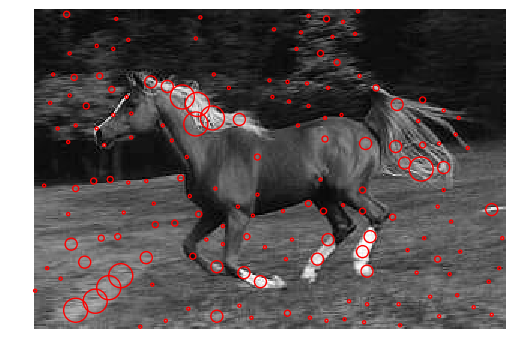

In [27]:
sigma_zero = 1
number_of_scales = 8
number_of_maxima = 2000
threshold = 11

run_experiment(img1, sigma_zero, number_of_scales, number_of_maxima, threshold)



Applying the blob detector to the following image, it can be observed that most of the blobs detected by the filter are small in size and mostly concentrated in the background. This is probably due to the threshold introduced on the number of maxima detected and the cleaning technique adopted in filtering the number of maxima.

Although the filter tends to respond more for small sigma it is possible to observe that it is able to detect blobs of larger size. Larger blobs are found in the lower left gray stripe on the grass and in the horse's white mane and legs. Blobs were also detected in the horsetail, in areas that appear to be fairly uniform in intenisty.

On average, the result obtained by the detector seems satisfactory, the detected spots have little varying intensity.

<h4><b>2.3 Test on image 2</b></h4>


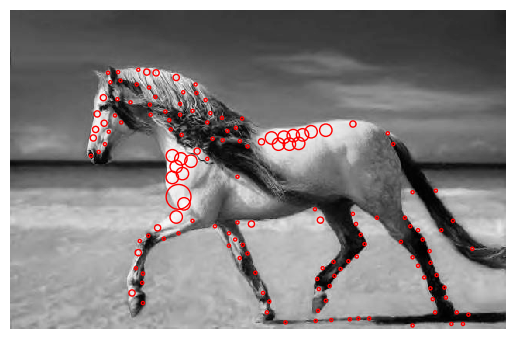

In [28]:
sigma_zero = 2
number_of_scales = 8
number_of_maxima = 2000
threshold = 11

run_experiment(img2, sigma_zero, number_of_scales, number_of_maxima, threshold)

From the application of the filter in the following image we definitely find a higher frequency in the detection of blobs of smaller size. Despite this in the horse silhouette larger blobs are detected in areas that are uniform in intensity (light intensity in this case). In this application of the filter, it is interesting to note that it is able to detect blobs in the shadow below the horse, which stands out against the much lighter background.

Finally, the filter is able to focus optimally on the horse figure while ignoring the uniform, "flat" background.

<h4><b>2.4 Test on image 3</b></h4>


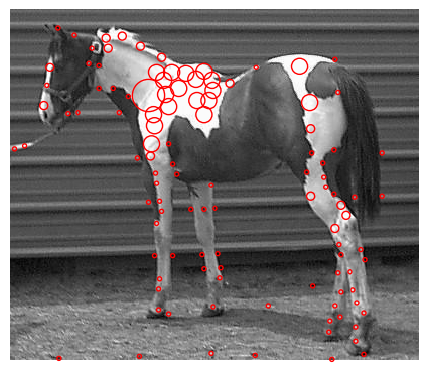

In [29]:
sigma_zero = 2
number_of_scales = 8
number_of_maxima = 2500
threshold = 10

run_experiment(img3, sigma_zero, number_of_scales, number_of_maxima, threshold)

Also in this final detector test we can observe that the filter focuses more on the horse silhouette rather than the background. In this case the filter equally detects small and medium sized blobs, except for one large blob on the neck.

Particularly interesting in this test are the blobs found: on the rope that binds the horse's face which stands out from the background, the blobs on the horse's nose, mane, and butt which seem particularly well centered, and also the larger blob on the neck.

<h4><b>3. CONSIDERATIONS</b></h4>




Implementing the blob detector, main challenges involved identifying the maximum response points of the filter and implementing a filtering system for the local maxima identified on the convolved image. During this phase, critical choices were made regarding which maxima to consider, how to apply the filtering system, which positions to consider relevant and the minimum distance between two blob centers.

The simplifications adopted at these stages are the main weakness of the implementation, as they may introduce some degree of bias into the identified blobs. However, tests conducted on the images showed that the implementation choices lead to satisfactory and meaningful results.

To improve the detector, a more accurate approach for filtering maxima, possibly also based on the sigma value, could be considered. This could allow not excluding blobs with higher sigma values, which tend to show lower responses to LoG filtering.